In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Input, Dense, GRU, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
#from tensorflow.python.keras.models import Sequential
#from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
#from tensorflow.python.keras.optimizers import RMSprop
#from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
print ('-This section done-')

import sys
sys.path.append("/Users/omerorhan/Desktop/UCSC/Deep Learning/DeepLearningUCSC/venv/homework/Assignments/") 


-This section done-


In [3]:


#data_dir = "data/weather-denmark/"
data_dir = ""


# Full path for the pickled data-file. (Original data).
def path_original_data_pickle():
    return os.path.join(data_dir, "weather-denmark.pkl")


# Full path for the comma-separated text-file. (Original data).
def path_original_data_csv():
    return os.path.join(data_dir, "weather-denmark.csv")


# Full path for the resampled data as a pickled file.
def path_resampled_data_pickle():
    return os.path.join(data_dir, "weather-denmark-resampled.pkl")


# URL for the data-set on the internet.
data_url = "https://github.com/Hvass-Labs/weather-denmark/raw/master/weather-denmark.tar.gz"


# List of the cities in this data-set. These are cities in Denmark.
cities = ['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']


########################################################################
# Private helper-functions.


def _date_string(x):
    """Convert two integers to a string for the date and time."""

    date = x[0]  # Date. Example: 19801231
    time = x[1]  # Time. Example: 1230

    return "{0}{1:04d}".format(date, time)


def _usaf_to_city(usaf):
    """
    The raw data-file uses USAF-codes to identify weather-stations.
    If you download another data-set from NCDC then you will have to
    change this function to use the USAF-codes in your new data-file.
    """

    table = \
        {
            60300: 'Aalborg',
            60700: 'Aarhus',
            60800: 'Esbjerg',
            61200: 'Odense',
            61700: 'Roskilde'
        }

    return table[usaf]


def _convert_raw_data(path):
    """
    This converts a raw data-file obtained from the NCDC database.
    This function may be useful as an inspiration if you want to
    download another raw data-file from NCDC, but you will have
    to modify this function to match the data you have downloaded.
    Note that you may also have to manually edit the raw data-file,
    e.g. because the header is not in a proper comma-separated format.
    """

    # The raw CSV-file uses various markers for "not-available" (NA).
    # (This is one of several oddities with NCDC's file-format.)
    na_values = ['999', '999.0', '999.9', '9999.9']

    # Use Pandas to load the comma-separated file.
    # Note that you may have to manually edit the file's header
    # to get this to load correctly.
    df_raw = pd.read_csv(path, sep=',', header=1,
                         index_col=False, na_values=na_values)

    # Create a new data-frame containing only the data
    # we are interested in.
    df = pd.DataFrame()

    # Get the city-name / weather-station name from the USAF code.
    df['City'] = df_raw['USAF  '].apply(_usaf_to_city)

    # Convert the integer date-time to a proper date-time object.
    datestr = df_raw[['Date    ', 'HrMn']].apply(_date_string, axis=1)
    df['DateTime'] = pd.to_datetime(datestr, format='%Y%m%d%H%M')

    # Get the data we are interested in.
    df['Temp'] = df_raw['Temp  ']
    df['Pressure'] = df_raw['Slp   ']
    df['WindSpeed'] = df_raw['Spd  ']
    df['WindDir'] = df_raw['Dir']

    # Set the city-name and date-time as the index.
    df.set_index(['City', 'DateTime'], inplace=True)

    # Save the new data-frame as a pickle for fast reloading.
    df.to_pickle(path_original_data_pickle())

    # Save the new data-frame as a CSV-file for general readability.
    df.to_csv(path_original_data_csv())

    return df


def _resample(df):
    """
    Resample the contents of a Pandas data-frame by first
    removing empty rows and columns, then up-sampling and
    interpolating the data for 1-minute intervals, and
    finally down-sampling to 60-minute intervals.
    """

    # Remove all empty rows and columns.
    df_res = df.dropna(axis=[0, 1], how='all')

    # Upsample so the time-series has data for every minute.
    df_res = df_res.resample('1T')

    # Fill in missing values.
    df_res = df_res.interpolate(method='time')

    # Downsample so the time-series has data for every hour.
    df_res = df_res.resample('60T')

    # Finalize the resampling. (Is this really necessary?)
    df_res = df_res.interpolate()

    # Remove all empty rows.
    df_res = df_res.dropna(how='all')

    return df_res


########################################################################
# Public functions that you may call to download the data-set from
# the internet and load the data into memory.


def maybe_download_and_extract():
    """
    Download and extract the weather-data if the data-files don't
    already exist in the data_dir.
    """

    download.maybe_download_and_extract(url=data_url, download_dir=data_dir)


def load_original_data():
    """
    Load and return the original data that has not been resampled.
    
    Note that this is not the raw data obtained from NCDC.
    It is a cleaned-up version of that data, as written by the
    function _convert_raw_data() above.
    """

    return pd.read_pickle(path_original_data_pickle())


def load_resampled_data():
    """
    Load and return the resampled weather-data.
    This has data-points at regular 60-minute intervals where
    missing data has been linearly interpolated.
    This uses a cache-file for saving and quickly reloading the data,
    so the original data is only resampled once.
    """

    # Path for the cache-file with the resampled data.
    path = path_resampled_data_pickle()

    # If the cache-file exists ...
    if os.path.exists(path):
        # Reload the cache-file.
        df = pd.read_pickle(path)
    else:
        # Otherwise resample the original data and save it in a cache-file.

        # Load the original data.
        df_org = load_original_data()

        # Split the original data into separate data-frames for each city.
        df_cities = [df_org.xs(city) for city in cities]

        # Resample the data for each city.
        df_resampled = [_resample(df_city) for df_city in df_cities]

        # Join the resampled data into a single data-frame.
        df = pd.concat(df_resampled, keys=cities,
                       axis=1, join='inner')

        # Save the resampled data in a cache-file for quick reloading.
        df.to_pickle(path)

    return df
print ('-This section done-')

-This section done-


In [4]:
import weather
print ('-This section done-')

-This section done-


In [5]:
weather.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [6]:
cities = weather.cities
print(cities)

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']


In [7]:
%%time
df = weather.load_resampled_data()
print ('-This section done-')

-This section done-
CPU times: user 55.3 ms, sys: 98.8 ms, total: 154 ms
Wall time: 218 ms


In [8]:
df.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead tr th {
        text-align: left;
    }

    .dataframe thead tr:last-of-type th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="4" halign="left">Aalborg</th>
      <th colspan="4" halign="left">Aarhus</th>
      <th colspan="4" halign="left">Esbjerg</th>
      <th colspan="4" halign="left">Odense</th>
      <th colspan="4" halign="left">Roskilde</th>
    </tr>
    <tr>
      <th></th>
      <th>Temp</th>
      <th>Pressure</th>
      <th>WindSpeed</th>
      <th>WindDir</th>
      <th>Temp</th>
      <th>Pressure</th>
      <th>WindSpeed</th>
      <th>WindDir</th>
      <th>Temp</th>
      <th>Pressure</th>
      <th>WindSpeed</th>
      <th>WindDir</th>
      <th>Temp</th>
      <th>Pressure</th>
      <th>WindSpeed</th>
      <th>WindDir</th>
      <th>Temp</th>
      <th>Pressure</th>
      <th>WindSpeed</th>
      <th>WindDir</th>
    </tr>
    <tr>
      <th>DateTime</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1980-03-01 11:00:00</th>
      <td>5.000000</td>
      <td>1007.766667</td>
      <td>10.2</td>
      <td>280.000000</td>
      <td>5.0</td>
      <td>1008.300000</td>
      <td>15.4</td>
      <td>290.0</td>
      <td>6.083333</td>
      <td>NaN</td>
      <td>12.383333</td>
      <td>310.000000</td>
      <td>6.142857</td>
      <td>1011.066667</td>
      <td>12.585714</td>
      <td>290.0</td>
      <td>5.000000</td>
      <td>NaN</td>
      <td>11.466667</td>
      <td>280.000000</td>
    </tr>
    <tr>
      <th>1980-03-01 12:00:00</th>
      <td>5.000000</td>
      <td>1008.000000</td>
      <td>10.3</td>
      <td>290.000000</td>
      <td>5.0</td>
      <td>1008.600000</td>
      <td>13.4</td>
      <td>280.0</td>
      <td>6.583333</td>
      <td>NaN</td>
      <td>12.883333</td>
      <td>310.000000</td>
      <td>7.000000</td>
      <td>1011.200000</td>
      <td>11.300000</td>
      <td>290.0</td>
      <td>5.000000</td>
      <td>NaN</td>
      <td>12.466667</td>
      <td>280.000000</td>
    </tr>
    <tr>
      <th>1980-03-01 13:00:00</th>
      <td>5.000000</td>
      <td>1008.066667</td>
      <td>9.7</td>
      <td>290.000000</td>
      <td>5.0</td>
      <td>1008.433333</td>
      <td>15.4</td>
      <td>280.0</td>
      <td>6.888889</td>
      <td>NaN</td>
      <td>13.244444</td>
      <td>309.444444</td>
      <td>7.000000</td>
      <td>1011.300000</td>
      <td>12.118182</td>
      <td>290.0</td>
      <td>5.166667</td>
      <td>NaN</td>
      <td>13.133333</td>
      <td>278.333333</td>
    </tr>
    <tr>
      <th>1980-03-01 14:00:00</th>
      <td>4.333333</td>
      <td>1008.133333</td>
      <td>11.1</td>
      <td>283.333333</td>
      <td>5.0</td>
      <td>1008.266667</td>
      <td>14.9</td>
      <td>300.0</td>
      <td>6.222222</td>
      <td>NaN</td>
      <td>12.911111</td>
      <td>306.111111</td>
      <td>6.857143</td>
      <td>1011.400000</td>
      <td>12.742857</td>
      <td>290.0</td>
      <td>5.833333</td>
      <td>NaN</td>
      <td>12.300000</td>
      <td>270.000000</td>
    </tr>
    <tr>
      <th>1980-03-01 15:00:00</th>
      <td>4.000000</td>
      <td>1008.200000</td>
      <td>11.3</td>
      <td>280.000000</td>
      <td>5.0</td>
      <td>1008.100000</td>
      <td>17.0</td>
      <td>290.0</td>
      <td>5.555556</td>
      <td>NaN</td>
      <td>12.577778</td>
      <td>302.777778</td>
      <td>6.000000</td>
      <td>1011.500000</td>
      <td>12.40000

-This section done-


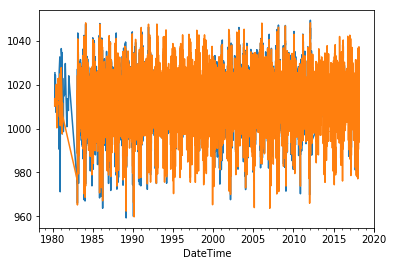

In [9]:
# To Take care of Missing Data:::
df['Esbjerg']['Pressure'].plot()
df['Roskilde']['Pressure'].plot()
print ('-This section done-')

In [10]:
print(df.values.shape)
print ('-This section done-')

(333109, 20)
-This section done-


In [11]:
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)
print ('-This section done-')

-This section done-


In [12]:
df.values.shape
print ('-This section done-')

-This section done-


In [13]:
print(df.head(1))


                    Aalborg                                Aarhus           \
                       Temp     Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                     
1980-03-01 11:00:00     5.0  1007.766667      10.2   280.0    5.0   1008.3   

                                        Esbjerg                       Odense  \
                    WindSpeed WindDir      Temp  WindSpeed WindDir      Temp   
DateTime                                                                       
1980-03-01 11:00:00      15.4   290.0  6.083333  12.383333   310.0  6.142857   

                                                    Roskilde             \
                        Pressure  WindSpeed WindDir     Temp  WindSpeed   
DateTime                                                                  
1980-03-01 11:00:00  1011.066667  12.585714   290.0      5.0  11.466667   

                             
                    WindDir  
DateT

In [14]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour
print ('-This section done-')

-This section done-


In [15]:
# Predict for city Odense: ['Temp', 'WindSpeed', 'Pressure'] 
target_city = 'Odense'
target_names = ['Temp', 'WindSpeed', 'Pressure']
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.
df_targets = df[target_city][target_names].shift(-shift_steps)
df[target_city][target_names].head(shift_steps + 5)
print ('-This section done-')

-This section done-


In [16]:
df_targets.head(5)
print ('-This section done-')

-This section done-


In [17]:
# Converting Data Frames to Numpy array::::

x_data = df.values[0:-shift_steps]
print("X_Shape::::")
print(type(x_data))
print("Shape:", x_data.shape)

print("Y_Shape::::")
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

num_data = len(x_data)
print("# of input data ",num_data)

train_split = 0.9

num_train = int(train_split * num_data)
print("# of Training data: ",num_train)

num_test = num_data - num_train
print("# of Test data: ",num_test)

x_train = x_data[0:num_train]
x_test = x_data[num_train:]

y_train = y_data[0:num_train]
y_test = y_data[num_train:]

num_x_signals = x_data.shape[1]

num_y_signals = y_data.shape[1]

print(num_x_signals)
print(num_y_signals)
print ('-This section done-')

X_Shape::::
<class 'numpy.ndarray'>
Shape: (333085, 20)
Y_Shape::::
<class 'numpy.ndarray'>
Shape: (333085, 3)
# of input data  333085
# of Training data:  299776
# of Test data:  33309
20
3
-This section done-


In [18]:
# Scaling data

#The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use scikit-learn for this.

x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print ('-This section done-')

Min: 0.0
Max: 1.0000000000000002
-This section done-


In [19]:
#Data Generator
print(x_train_scaled.shape)
print(y_train_scaled.shape)

def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)
        
print ('-This section done-')

(299776, 20)
(299776, 3)
-This section done-


In [20]:
batch_size = 256
sequence_length = 24 * 7 * 8
sequence_length

1344

(256, 1344, 20)
(256, 1344, 3)


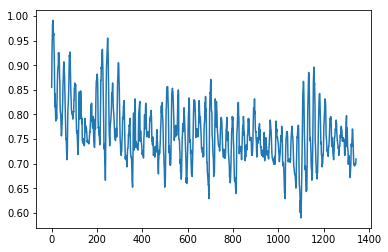

In [21]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)
plt.show()

In [22]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))
print ('-This section done-')
print(x_test_scaled.shape)

-This section done-
(33309, 20)


In [23]:
lookback = 240
step = 6
delay = 144
batch_size = 128
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


train_gen = generator(x_test_scaled,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=20000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(x_test_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=20001,
                    max_index=30000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(x_test_scaled,
                     lookback=lookback,
                     delay=delay,
                     min_index=30001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


val_steps = (30000 - 20001 - lookback)

test_steps = (len(x_test_scaled) - 30001 - lookback)



In [24]:

from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, x_train_scaled.shape[-1]))) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae') 
history = model.fit_generator(train_gen,
steps_per_epoch=500, epochs=4, validation_data=val_gen, validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Epoch 1/4


  1/500 [..............................] - ETA: 3:34 - loss: 0.2017

  9/500 [..............................] - ETA: 26s - loss: 0.7740 

 18/500 [>.............................] - ETA: 14s - loss: 0.5476

 25/500 [>.............................] - ETA: 11s - loss: 0.4629

 32/500 [>.............................] - ETA: 9s - loss: 0.4132 

 39/500 [=>............................] - ETA: 8s - loss: 0.3779

 47/500 [=>............................] - ETA: 7s - loss: 0.3538

 55/500 [==>...........................] - ETA: 6s - loss: 0.3355

 62/500 [==>...........................] - ETA: 6s - loss: 0.3280

 68/500 [===>..........................] - ETA: 5s - loss: 0.3167

 73/500 [===>..........................] - ETA: 5s - loss: 0.3162

 77/500 [===>..........................] - ETA: 5s - loss: 0.3093

 82/500 [===>..........................] - ETA: 5s - loss: 0.3021

 90/500 [====>.........................] - ETA: 5s - loss: 0.2916

 99/500 [====>.........................] - ETA: 4s - loss: 0.2835

106/500 [=====>........................] - ETA: 4s - loss: 0.2777

114/500 [=====>........................] - ETA: 4s - loss: 0.2714

120/500 [======>.......................] - ETA: 4s - loss: 0.2669

126/500 [======>.......................] - ETA: 4s - loss: 0.2628

135/500 [=======>......................] - ETA: 3s - loss: 0.2573

143/500 [=======>......................] - ETA: 3s - loss: 0.2531

151/500 [========>.....................] - ETA: 3s - loss: 0.2504

160/500 [========>.....................] - ETA: 3s - loss: 0.2461

168/500 [=========>....................] - ETA: 3s - loss: 0.2421

175/500 [=========>....................] - ETA: 3s - loss: 0.2398

183/500 [=========>....................] - ETA: 3s - loss: 0.2367

191/500 [==========>...................] - ETA: 2s - loss: 0.2340

199/500 [==========>...................] - ETA: 2s - loss: 0.2306

207/500 [===========>..................] - ETA: 2s - loss: 0.2294

214/500 [===========>..................] - ETA: 2s - loss: 0.2274

221/500 [============>.................] - ETA: 2s - loss: 0.2254

229/500 [============>.................] - ETA: 2s - loss: 0.2236

237/500 [=============>................] - ETA: 2s - loss: 0.2219

244/500 [=============>................] - ETA: 2s - loss: 0.2202

251/500 [==============>...............] - ETA: 2s - loss: 0.2190

260/500 [==============>...............] - ETA: 2s - loss: 0.2172

266/500 [==============>...............] - ETA: 2s - loss: 0.2162

273/500 [===============>..............] - ETA: 2s - loss: 0.2148

280/500 [===============>..............] - ETA: 1s - loss: 0.2131

287/500 [================>.............] - ETA: 1s - loss: 0.2119

294/500 [================>.............] - ETA: 1s - loss: 0.2106

301/500 [=================>............] - ETA: 1s - loss: 0.2095

309/500 [=================>............] - ETA: 1s - loss: 0.2083

317/500 [==================>...........] - ETA: 1s - loss: 0.2070

324/500 [==================>...........] - ETA: 1s - loss: 0.2059

331/500 [==================>...........] - ETA: 1s - loss: 0.2051

337/500 [===================>..........] - ETA: 1s - loss: 0.2043

342/500 [===================>..........] - ETA: 1s - loss: 0.2035

348/500 [===================>..........] - ETA: 1s - loss: 0.2027

355/500 [====================>.........] - ETA: 1s - loss: 0.2019

362/500 [====================>.........] - ETA: 1s - loss: 0.2012

370/500 [=====================>........] - ETA: 1s - loss: 0.1998

377/500 [=====================>........] - ETA: 1s - loss: 0.1991

385/500 [======================>.......] - ETA: 0s - loss: 0.1982

391/500 [======================>.......] - ETA: 0s - loss: 0.1973

394/500 [======================>.......] - ETA: 0s - loss: 0.1971

397/500 [======================>.......] - ETA: 0s - loss: 0.1967

402/500 [=======================>......] - ETA: 0s - loss: 0.1963

409/500 [=======================>......] - ETA: 0s - loss: 0.1955

416/500 [=======================>......] - ETA: 0s - loss: 0.1947

424/500 [========================>.....] - ETA: 0s - loss: 0.1939

431/500 [========================>.....] - ETA: 0s - loss: 0.1931

439/500 [=========================>....] - ETA: 0s - loss: 0.1922

447/500 [=========================>....] - ETA: 0s - loss: 0.1913

454/500 [==========================>...] - ETA: 0s - loss: 0.1906

462/500 [==========================>...] - ETA: 0s - loss: 0.1897

469/500 [===========================>..] - ETA: 0s - loss: 0.1886

477/500 [===========================>..] - ETA: 0s - loss: 0.1871

485/500 [============================>.] - ETA: 0s - loss: 0.1860

492/500 [============================>.] - ETA: 0s - loss: 0.1849

499/500 [============================>.] - ETA: 0s - loss: 0.1839

500/500 [==============================] - 48s 97ms/step - loss: 0.1837 - val_loss: 0.1074


Epoch 2/4
  1/500 [..............................] - ETA: 2s - loss: 0.1005

  7/500 [..............................] - ETA: 4s - loss: 0.1133

 14/500 [..............................] - ETA: 3s - loss: 0.1100

 20/500 [>.............................] - ETA: 3s - loss: 0.1094

 28/500 [>.............................] - ETA: 3s - loss: 0.1079

 37/500 [=>............................] - ETA: 3s - loss: 0.1096

 46/500 [=>............................] - ETA: 3s - loss: 0.1090

 55/500 [==>...........................] - ETA: 3s - loss: 0.1079

 64/500 [==>...........................] - ETA: 2s - loss: 0.1085

 72/500 [===>..........................] - ETA: 2s - loss: 0.1076

 80/500 [===>..........................] - ETA: 2s - loss: 0.1082

 88/500 [====>.........................] - ETA: 2s - loss: 0.1068

 96/500 [====>.........................] - ETA: 2s - loss: 0.1078

104/500 [=====>........................] - ETA: 2s - loss: 0.1081

112/500 [=====>........................] - ETA: 2s - loss: 0.1077

120/500 [======>.......................] - ETA: 2s - loss: 0.1079

128/500 [======>.......................] - ETA: 2s - loss: 0.1086

137/500 [=======>......................] - ETA: 2s - loss: 0.1080

145/500 [=======>......................] - ETA: 2s - loss: 0.1081

153/500 [========>.....................] - ETA: 2s - loss: 0.1077

161/500 [========>.....................] - ETA: 2s - loss: 0.1074

169/500 [=========>....................] - ETA: 2s - loss: 0.1071

178/500 [=========>....................] - ETA: 2s - loss: 0.1071

186/500 [==========>...................] - ETA: 2s - loss: 0.1069

194/500 [==========>...................] - ETA: 1s - loss: 0.1067

203/500 [===========>..................] - ETA: 1s - loss: 0.1068

211/500 [===========>..................] - ETA: 1s - loss: 0.1067

220/500 [============>.................] - ETA: 1s - loss: 0.1068

228/500 [============>.................] - ETA: 1s - loss: 0.1067

235/500 [=============>................] - ETA: 1s - loss: 0.1063

243/500 [=============>................] - ETA: 1s - loss: 0.1065

250/500 [==============>...............] - ETA: 1s - loss: 0.1064

258/500 [==============>...............] - ETA: 1s - loss: 0.1062

266/500 [==============>...............] - ETA: 1s - loss: 0.1063

274/500 [===============>..............] - ETA: 1s - loss: 0.1063

282/500 [===============>..............] - ETA: 1s - loss: 0.1060

290/500 [================>.............] - ETA: 1s - loss: 0.1058

298/500 [================>.............] - ETA: 1s - loss: 0.1057

306/500 [=================>............] - ETA: 1s - loss: 0.1055

314/500 [=================>............] - ETA: 1s - loss: 0.1055

322/500 [==================>...........] - ETA: 1s - loss: 0.1053

330/500 [==================>...........] - ETA: 1s - loss: 0.1051

338/500 [===================>..........] - ETA: 1s - loss: 0.1052

347/500 [===================>..........] - ETA: 0s - loss: 0.1052

355/500 [====================>.........] - ETA: 0s - loss: 0.1051

364/500 [====================>.........] - ETA: 0s - loss: 0.1050

373/500 [=====================>........] - ETA: 0s - loss: 0.1049

382/500 [=====================>........] - ETA: 0s - loss: 0.1047

390/500 [======================>.......] - ETA: 0s - loss: 0.1048

399/500 [======================>.......] - ETA: 0s - loss: 0.1047

408/500 [=======================>......] - ETA: 0s - loss: 0.1047

417/500 [========================>.....] - ETA: 0s - loss: 0.1046

425/500 [========================>.....] - ETA: 0s - loss: 0.1046

434/500 [=========================>....] - ETA: 0s - loss: 0.1044

443/500 [=========================>....] - ETA: 0s - loss: 0.1043

451/500 [==========================>...] - ETA: 0s - loss: 0.1043

460/500 [==========================>...] - ETA: 0s - loss: 0.1043

468/500 [===========================>..] - ETA: 0s - loss: 0.1041

477/500 [===========================>..] - ETA: 0s - loss: 0.1040

486/500 [============================>.] - ETA: 0s - loss: 0.1039

495/500 [============================>.] - ETA: 0s - loss: 0.1041

500/500 [==============================] - 47s 93ms/step - loss: 0.1039 - val_loss: 0.1135


Epoch 3/4
  1/500 [..............................] - ETA: 1s - loss: 0.1061

  7/500 [..............................] - ETA: 4s - loss: 0.0975

 15/500 [..............................] - ETA: 3s - loss: 0.0985

 20/500 [>.............................] - ETA: 4s - loss: 0.0975

 29/500 [>.............................] - ETA: 3s - loss: 0.0982

 38/500 [=>............................] - ETA: 3s - loss: 0.0967

 46/500 [=>............................] - ETA: 3s - loss: 0.0984

 55/500 [==>...........................] - ETA: 3s - loss: 0.0979

 63/500 [==>...........................] - ETA: 3s - loss: 0.0982

 72/500 [===>..........................] - ETA: 2s - loss: 0.0987

 80/500 [===>..........................] - ETA: 2s - loss: 0.0983

 89/500 [====>.........................] - ETA: 2s - loss: 0.0983

 97/500 [====>.........................] - ETA: 2s - loss: 0.0983

106/500 [=====>........................] - ETA: 2s - loss: 0.0983

115/500 [=====>........................] - ETA: 2s - loss: 0.0982

124/500 [======>.......................] - ETA: 2s - loss: 0.0978

133/500 [======>.......................] - ETA: 2s - loss: 0.0980

142/500 [=======>......................] - ETA: 2s - loss: 0.0978

151/500 [========>.....................] - ETA: 2s - loss: 0.0978

160/500 [========>.....................] - ETA: 2s - loss: 0.0975

168/500 [=========>....................] - ETA: 2s - loss: 0.0976

176/500 [=========>....................] - ETA: 2s - loss: 0.0974

185/500 [==========>...................] - ETA: 2s - loss: 0.0971

193/500 [==========>...................] - ETA: 1s - loss: 0.0971

202/500 [===========>..................] - ETA: 1s - loss: 0.0969

211/500 [===========>..................] - ETA: 1s - loss: 0.0969

220/500 [============>.................] - ETA: 1s - loss: 0.0970

228/500 [============>.................] - ETA: 1s - loss: 0.0968

237/500 [=============>................] - ETA: 1s - loss: 0.0968

245/500 [=============>................] - ETA: 1s - loss: 0.0965

254/500 [==============>...............] - ETA: 1s - loss: 0.0965

263/500 [==============>...............] - ETA: 1s - loss: 0.0964

271/500 [===============>..............] - ETA: 1s - loss: 0.0965

279/500 [===============>..............] - ETA: 1s - loss: 0.0965

287/500 [================>.............] - ETA: 1s - loss: 0.0964

296/500 [================>.............] - ETA: 1s - loss: 0.0963

305/500 [=================>............] - ETA: 1s - loss: 0.0962

313/500 [=================>............] - ETA: 1s - loss: 0.0963

321/500 [==================>...........] - ETA: 1s - loss: 0.0963

329/500 [==================>...........] - ETA: 1s - loss: 0.0962

338/500 [===================>..........] - ETA: 1s - loss: 0.0963

346/500 [===================>..........] - ETA: 0s - loss: 0.0962

355/500 [====================>.........] - ETA: 0s - loss: 0.0962

364/500 [====================>.........] - ETA: 0s - loss: 0.0961

373/500 [=====================>........] - ETA: 0s - loss: 0.0961

381/500 [=====================>........] - ETA: 0s - loss: 0.0961

390/500 [======================>.......] - ETA: 0s - loss: 0.0961

399/500 [======================>.......] - ETA: 0s - loss: 0.0959

407/500 [=======================>......] - ETA: 0s - loss: 0.0959

415/500 [=======================>......] - ETA: 0s - loss: 0.0958

424/500 [========================>.....] - ETA: 0s - loss: 0.0958

433/500 [========================>.....] - ETA: 0s - loss: 0.0956

442/500 [=========================>....] - ETA: 0s - loss: 0.0956

449/500 [=========================>....] - ETA: 0s - loss: 0.0955

457/500 [==========================>...] - ETA: 0s - loss: 0.0956

465/500 [==========================>...] - ETA: 0s - loss: 0.0954

473/500 [===========================>..] - ETA: 0s - loss: 0.0955

481/500 [===========================>..] - ETA: 0s - loss: 0.0954

489/500 [============================>.] - ETA: 0s - loss: 0.0953

497/500 [============================>.] - ETA: 0s - loss: 0.0952

500/500 [==============================] - 47s 93ms/step - loss: 0.0952 - val_loss: 0.0984


Epoch 4/4
  1/500 [..............................] - ETA: 1s - loss: 0.0956

 10/500 [..............................] - ETA: 2s - loss: 0.0956

 17/500 [>.............................] - ETA: 3s - loss: 0.0927

 22/500 [>.............................] - ETA: 3s - loss: 0.0932

 27/500 [>.............................] - ETA: 3s - loss: 0.0936

 36/500 [=>............................] - ETA: 3s - loss: 0.0936

 45/500 [=>............................] - ETA: 3s - loss: 0.0919

 52/500 [==>...........................] - ETA: 3s - loss: 0.0921

 60/500 [==>...........................] - ETA: 3s - loss: 0.0922

 69/500 [===>..........................] - ETA: 3s - loss: 0.0921

 77/500 [===>..........................] - ETA: 2s - loss: 0.0918

 85/500 [====>.........................] - ETA: 2s - loss: 0.0918

 93/500 [====>.........................] - ETA: 2s - loss: 0.0919

101/500 [=====>........................] - ETA: 2s - loss: 0.0917

109/500 [=====>........................] - ETA: 2s - loss: 0.0914

118/500 [======>.......................] - ETA: 2s - loss: 0.0915

126/500 [======>.......................] - ETA: 2s - loss: 0.0913

135/500 [=======>......................] - ETA: 2s - loss: 0.0914

144/500 [=======>......................] - ETA: 2s - loss: 0.0912

153/500 [========>.....................] - ETA: 2s - loss: 0.0915

162/500 [========>.....................] - ETA: 2s - loss: 0.0915

170/500 [=========>....................] - ETA: 2s - loss: 0.0916

179/500 [=========>....................] - ETA: 2s - loss: 0.0915

188/500 [==========>...................] - ETA: 2s - loss: 0.0914

196/500 [==========>...................] - ETA: 1s - loss: 0.0914

205/500 [===========>..................] - ETA: 1s - loss: 0.0912

213/500 [===========>..................] - ETA: 1s - loss: 0.0911

222/500 [============>.................] - ETA: 1s - loss: 0.0912

231/500 [============>.................] - ETA: 1s - loss: 0.0911

240/500 [=============>................] - ETA: 1s - loss: 0.0910

248/500 [=============>................] - ETA: 1s - loss: 0.0912

257/500 [==============>...............] - ETA: 1s - loss: 0.0909

266/500 [==============>...............] - ETA: 1s - loss: 0.0909

274/500 [===============>..............] - ETA: 1s - loss: 0.0909

282/500 [===============>..............] - ETA: 1s - loss: 0.0908

291/500 [================>.............] - ETA: 1s - loss: 0.0906

299/500 [================>.............] - ETA: 1s - loss: 0.0906

307/500 [=================>............] - ETA: 1s - loss: 0.0905

313/500 [=================>............] - ETA: 1s - loss: 0.0904

321/500 [==================>...........] - ETA: 1s - loss: 0.0903

329/500 [==================>...........] - ETA: 1s - loss: 0.0903

338/500 [===================>..........] - ETA: 1s - loss: 0.0903

346/500 [===================>..........] - ETA: 0s - loss: 0.0903

354/500 [====================>.........] - ETA: 0s - loss: 0.0904

362/500 [====================>.........] - ETA: 0s - loss: 0.0902

370/500 [=====================>........] - ETA: 0s - loss: 0.0903

378/500 [=====================>........] - ETA: 0s - loss: 0.0902



386/500 [======================>.......] - ETA: 0s - loss: 0.0902

393/500 [======================>.......] - ETA: 0s - loss: 0.0902

401/500 [=======================>......] - ETA: 0s - loss: 0.0901

410/500 [=======================>......] - ETA: 0s - loss: 0.0901

418/500 [========================>.....] - ETA: 0s - loss: 0.0902

426/500 [========================>.....] - ETA: 0s - loss: 0.0902

434/500 [=========================>....] - ETA: 0s - loss: 0.0902

442/500 [=========================>....] - ETA: 0s - loss: 0.0902

450/500 [==========================>...] - ETA: 0s - loss: 0.0901

458/500 [==========================>...] - ETA: 0s - loss: 0.0901

467/500 [===========================>..] - ETA: 0s - loss: 0.0900

474/500 [===========================>..] - ETA: 0s - loss: 0.0900

482/500 [===========================>..] - ETA: 0s - loss: 0.0899

490/500 [============================>.] - ETA: 0s - loss: 0.0899

498/500 [============================>.] - ETA: 0s - loss: 0.0899

500/500 [==============================] - 46s 93ms/step - loss: 0.0899 - val_loss: 0.1027


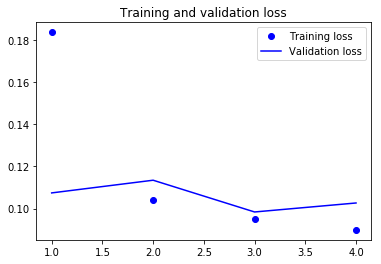

In [25]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()